In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [ ]:
df=pd.read_csv('hpi_master.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127329 entries, 0 to 127328
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hpi_type    127329 non-null  object 
 1   hpi_flavor  127329 non-null  object 
 2   frequency   127329 non-null  object 
 3   level       127329 non-null  object 
 4   place_name  127329 non-null  object 
 5   place_id    127329 non-null  object 
 6   yr          127329 non-null  int64  
 7   period      127329 non-null  int64  
 8   index_nsa   127328 non-null  float64
 9   index_sa    42525 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 9.7+ MB


,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
0,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,1,100.00,100.00
1,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,2,100.89,100.94
2,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,3,101.29,100.90
3,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,4,101.68,100.96
4,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,5,102.30,101.31


C:\Users\bhatr\AppData\Local\Temp\ipykernel_16192\2155614143.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical with mode


Mean Absolute Error (MAE): 20.81
Future Index SA Predictions: [240.31492559 239.93412059 240.0124899  239.68299613 239.00232597
 241.10644531 240.0581604  240.38765417 240.69008986 239.37749024]


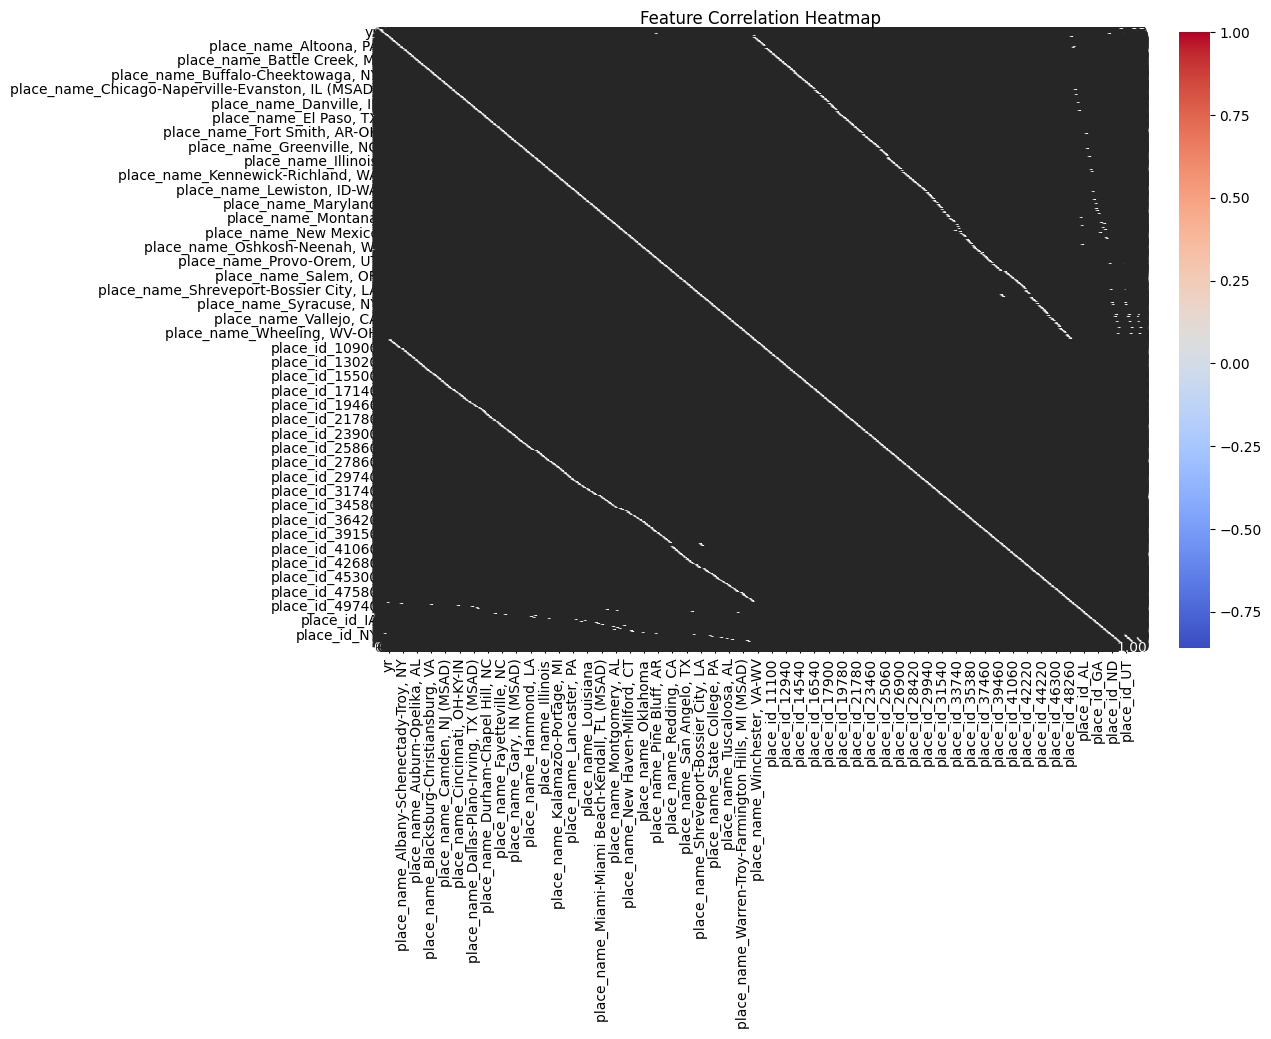

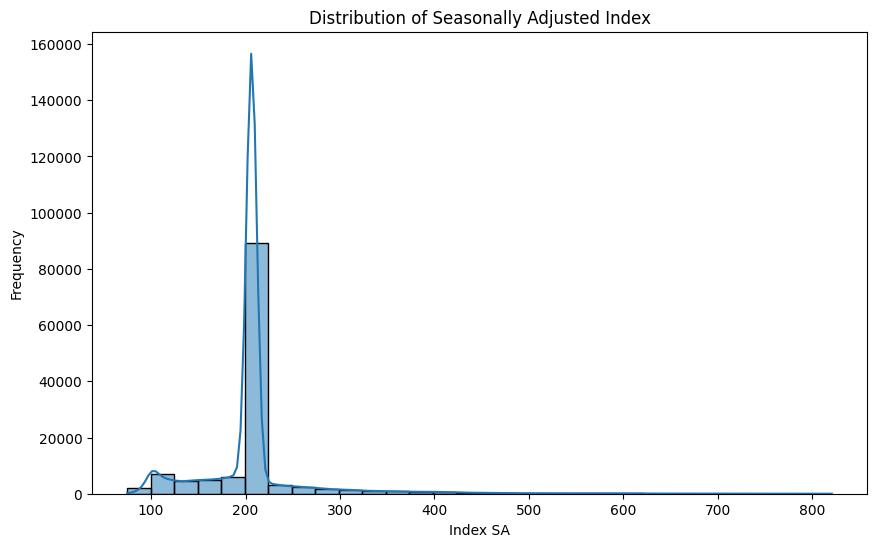

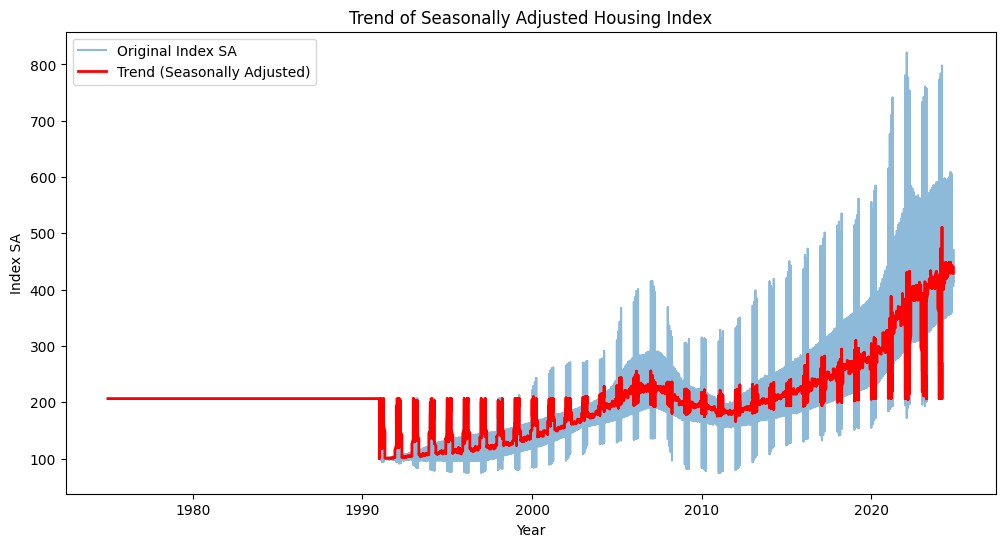

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

# ✅ Step 1: Load Dataset
df = pd.read_csv("hpi_master.csv")

# ✅ Step 2: Handle Missing Values
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)  # Fill categorical with mode

df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill numeric with mean

# ✅ Step 3: Convert Categorical Variables to Numeric
df = pd.get_dummies(df, drop_first=True, dtype=int)

# ✅ Step 4: Ensure "index_sa" is Numeric
df["index_sa"] = pd.to_numeric(df["index_sa"], errors="coerce")

# ✅ Step 5: Create a Time Index (Assuming `yr` and `period` Represent Year and Month)
df["date"] = pd.to_datetime(df["yr"].astype(str) + "-" + df["period"].astype(str), errors="coerce")

# ✅ Step 6: Set Time Index
df.set_index("date", inplace=True)
df.sort_index(inplace=True)  # Ensure chronological order

# ✅ Step 7: Apply Seasonal Decomposition
df = df.dropna(subset=["index_sa"])  # Drop rows where target is missing
decomposition = seasonal_decompose(df["index_sa"], model="additive", period=12)
df["index_sa_trend"] = decomposition.trend

# ✅ Step 8: Prepare Features and Target
df.dropna(subset=["index_sa_trend"], inplace=True)  # Drop missing trend values
X = df.drop(columns=["index_nsa", "index_sa", "index_sa_trend"], errors="ignore")
y = df["index_sa_trend"]

# ✅ Step 9: Ensure Proper Alignment
common_indices = X.index.intersection(y.index)
X_filtered = X.loc[common_indices]
y_filtered = y.loc[common_indices]

# Final check to prevent mismatched samples
assert len(X_filtered) == len(y_filtered), f"Mismatch: X={len(X_filtered)}, y={len(y_filtered)}"

# ✅ Step 10: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# ✅ Step 11: Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# ✅ Step 12: Predict & Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# ✅ Step 13: Future Forecasting
future_X = X_filtered.tail(10)  # Last 10 samples for future prediction
future_pred = model.predict(future_X)
print("Future Index SA Predictions:", future_pred)

# ✅ Step 14: Visualizations

# Heatmap: Feature Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Index SA Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["index_sa"].dropna(), kde=True, bins=30)
plt.xlabel("Index SA")
plt.ylabel("Frequency")
plt.title("Distribution of Seasonally Adjusted Index")
plt.show()

# Trend Plot
plt.figure(figsize=(12, 6))
plt.plot(df["index_sa"], label="Original Index SA", alpha=0.5)
plt.plot(df["index_sa_trend"], label="Trend (Seasonally Adjusted)", linewidth=2, color='red')
plt.xlabel("Year")
plt.ylabel("Index SA")
plt.title("Trend of Seasonally Adjusted Housing Index")
plt.legend()
plt.show()
